In [ ]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_PATH = '/kaggle/input/brain-tumor-segmentation'
print(TRAIN_PATH)

/kaggle/input/brain-tumor-segmentation


In [ ]:
# визуализация снимков

SIZE_X = 256
SIZE_Y = 256
TRAIN_PATH = '/kaggle/input/brain-tumor-segmentation'

images = []

for directory_path in sorted(glob.glob(TRAIN_PATH + '/images/')):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.uint8)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.merge([img, img, img])
        images.append(img)

images = np.array(images)

masks = []
for directory_path in sorted(glob.glob(TRAIN_PATH + '/masks/')):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        mask = mask / 255
        mask = mask.astype(np.uint8)
        masks.append(mask)

masks = np.array(masks)

n_samples = 3
plt.figure(figsize = (10, 10))
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(masks[i], cmap = 'gray')
# plot target image
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(images[i], cmap = 'gray')
plt.show()

print(f'IMAGES:\n'
f'Unique values: {np.unique(images)}\n'
f'Shape: {images.shape}\n'
f'Type: {images.dtype}\n\n'
f'MASKS:\n'
f'Unique values: {np.unique(masks)}\n'
f'Shape: {masks.shape}\n'
f'Type: {masks.dtype}')

In [ ]:
y = np.expand_dims(masks, axis = 3)
print(y.shape)

(3064, 256, 256, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape
train_masks_reshaped = masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)

[0 1]
(3064, 256, 256)


In [ ]:
# увеличение размерности, тк в tensorflow идет работа с тензорами
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = 3)
print(train_masks_input.shape)

(3064, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
# деление датасета на обучающий и тестовый наборы

X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input,
                                                    test_size = 0.15, shuffle = True, random_state = 42)

# деление датасета на обучающий и проверочный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.2, random_state = 42)

from tensorflow.keras.utils import to_categorical
n_classes = 2
train_masks_cat = to_categorical(y_train, num_classes = n_classes)
test_masks_cat = to_categorical(y_test, num_classes = n_classes)
val_masks_cat = to_categorical(y_val, num_classes = n_classes)

print(f'TRAIN SET:\n'
     f'X_train shape: {X_train.shape}\n'
     f'y_train shape: {train_masks_cat.shape}\n\n'
     f'VALIDATION SET:\n'
     f'X_val shape: {X_val.shape}\n'
     f'y_val shape: {val_masks_cat.shape}\n\n'
     f'TEST SET:\n'
     f'X_test shape: {X_test.shape}\n'
     f'y_test shape: {test_masks_cat.shape}')

TRAIN SET:
X_train shape: (2083, 256, 256, 3)
y_train shape: (2083, 256, 256, 2)

VALIDATION SET:
X_val shape: (521, 256, 256, 3)
y_val shape: (521, 256, 256, 2)

TEST SET:
X_test shape: (460, 256, 256, 3)
y_test shape: (460, 256, 256, 2)


In [ ]:
# Блоки модели

# Сверточный блок
def double_conv_block(x, n_filters):
    # свертка
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

# Блок понижения размерности (downsample)
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    # слой подвыборки
    p = MaxPool2D(2)(f)
    return f, p

# Блок повышения размерности (upsample)
def upsample_block(x, conv_features, n_filters):
    # транспонированная свертка
    x = Conv2DTranspose(n_filters, 3, 2, padding = "same")(x)
    # слой объединения (concatenation)
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# Модель

LR = 0.0001 # скорость обучения
optimizer = Adam(LR) # оптимизатор
activation = 'sigmoid' # функция активации выходного слоя
loss = 'binary_crossentropy' # функция потерь

# метрики: коэффициент Дайса-Сёренсена и Mean IoU
def dice_coef(y_true, y_pred, smooth = 1.0):
    class_num = 2 # классы: опухоль и фон
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

metrics = [dice_coef, tf.keras.metrics.MeanIoU(num_classes = n_classes)]
img_size = (256, 256, 3) # размерность изображения

def build_unet_model(img_size, num_classes):
    # вход
    inputs = Input(shape = img_size)
    # кодировщик
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # декодировщик
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # выход
    outputs = Conv2D(num_classes, 1, padding = "same", activation = activation)(u9)
    unet_model = tf.keras.Model(inputs, outputs, name = "U-Net")
    return unet_model

In [ ]:
# Модель
# Очистка RAM в случае, если ячейка с моделью запускалась несколько раз
K.clear_session()

unet_model = build_unet_model(img_size, n_classes)

# вывод сводной информации о модели
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

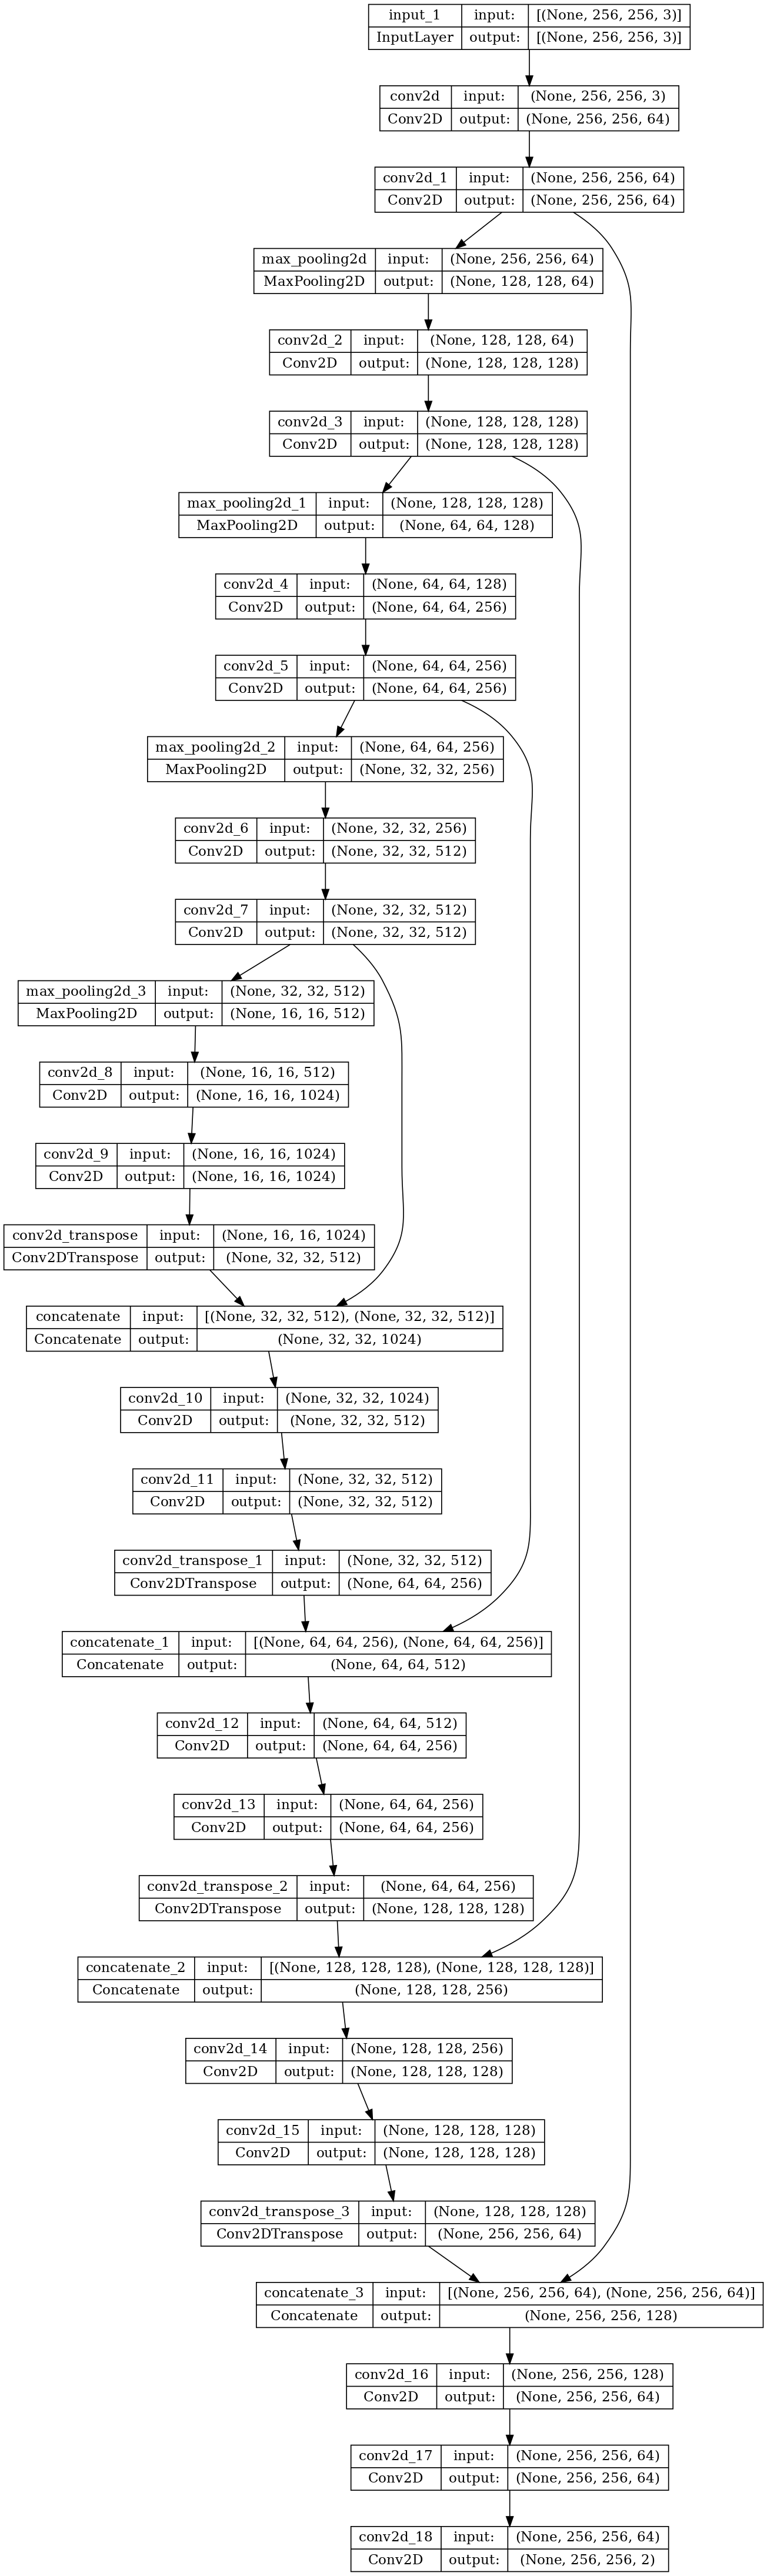

In [ ]:
# построение графика модели
plot_model(unet_model, show_shapes = True, show_layer_names = True, dpi = 120)

In [ ]:
# компиляция модели
unet_model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)

In [ ]:
# обучение
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

earlystopper = EarlyStopping(patience = 5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = '/kaggle/working/checkpoint.hdf5',
                               verbose = 1,
                               save_best_only = True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                              patience = 3, min_lr = 0.000001,
                              verbose = 1,  cooldown = 1)

history = unet_model.fit(X_train, train_masks_cat, batch_size = 10, epochs = 5, verbose = 1,
                        shuffle = True, callbacks = [earlystopper, checkpointer, reduce_lr],
                        validation_data = (X_val, val_masks_cat))

Epoch 1/5
209/209 [==============================] - ETA: 0s - loss: 0.1970 - dice_coef: 0.5284 - mean_io_u: 0.6449
Epoch 1: val_loss improved from inf to 0.07390, saving model to /kaggle/working/checkpoint.hdf5
209/209 [==============================] - 86s 324ms/step - loss: 0.1970 - dice_coef: 0.5284 - mean_io_u: 0.6449 - val_loss: 0.0739 - val_dice_coef: 0.5888 - val_mean_io_u: 0.6597 - lr: 1.0000e-04
Epoch 2/5
209/209 [==============================] - ETA: 0s - loss: 0.0640 - dice_coef: 0.6268 - mean_io_u: 0.6803
Epoch 2: val_loss improved from 0.07390 to 0.05966, saving model to /kaggle/working/checkpoint.hdf5
209/209 [==============================] - 64s 305ms/step - loss: 0.0640 - dice_coef: 0.6268 - mean_io_u: 0.6803 - val_loss: 0.0597 - val_dice_coef: 0.6107 - val_mean_io_u: 0.6680 - lr: 1.0000e-04
Epoch 3/5
209/209 [==============================] - ETA: 0s - loss: 0.0496 - dice_coef: 0.6825 - mean_io_u: 0.6790
Epoch 3: val_loss improved from 0.05966 to 0.04189, saving mod

In [ ]:
# вывод графиков обучения
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.plot(epochs, dice, 'b', label='Training Dice Score')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Score')
plt.title('Training and validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

# m_iou = history.history['mean_io_u_1']
# val_m_iou = history.history['val_mean_io_u_1']

# plt.plot(epochs, m_iou, 'b', label='Training Mean IoU')
# plt.plot(epochs, val_m_iou, 'r', label='Validation Mean IoU')
plt.title('Training and validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [ ]:
# оценка модели на тестовых снимках
unet_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
print("Evaluate on test data")
results = unet_model.evaluate(X_test, test_masks_cat, batch_size = 10)

In [ ]:
# сегментация тестовых снимков
from random import randint

test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()